In [13]:
import sys
import os 

os.environ["CONFIG_PATHS"] = "../../configs/small_model.yaml"
os.environ["CONFIG_OVERRIDES"] = 'game.moves_directory="../../data/moves_10"'
sys.path.append("../../src")

import matplotlib.pyplot as plt
import scipy.stats

from analysis import load_events, filter_events

In [14]:
events = load_events("../../data/2024-11-22_15-57-34-merited/logs_2024-11-22_16-15-56_157158.txt")

Start time: 1732319997.283125


In [15]:
for event in events:
    if event.name == "loaded_model":
        print(event.params)


{'model_name': '2024-11-20_09-34-23_478500'}
{'model_name': '2024-11-21_09-30-12_240898'}
{'model_name': '2024-11-22_09-47-50_646610'}
{'model_name': '2024-11-20_02-24-48_055438_s105769'}


In [16]:
game_result_events = filter_events(events, "game_result")
game_results = [event.params for event in game_result_events]

players = set()
for game_result in game_results:
    for player, _ in game_result:
        players.add(player)

print(len(game_results))

768


In [17]:
elos = [{player: 1000 for player in players}]

elo_K = 10.0
elo_base = 400.0

for game_result in game_results:
    latest_elo = elos[-1].copy()

    game_players = [player_name for player_name, _ in game_result]
    Q_player = [10 ** (latest_elo[player] / elo_base) for player in game_players]
    Q_total = sum(Q_player)
    E_player = [Q / Q_total for Q in Q_player]

    for i, (player, result) in enumerate(game_result):
        latest_elo[player] += elo_K * (result - E_player[i])

    elos.append(latest_elo)

In [18]:
results = {}
for game_result in game_results:
    for player, result in game_result:
        results[player] = results.get(player, 0) + result

total_results = sum(results.values())
for player in results:
    results[player] = results[player] / total_results

results

{'extracted_best': 0.1657986111111111,
 'chickpea_final': 0.1577690972222222,
 'overbragging_best': 0.5529513888888888,
 'extracted_final': 0.12348090277777775}

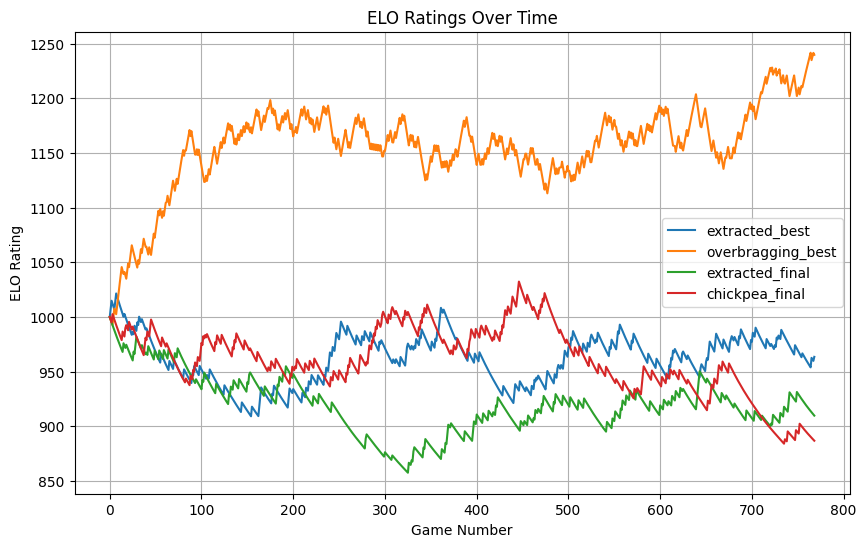

In [19]:
# # Extract player names from the first dictionary in elos
# player_names = elos[0].keys()

# # Prepare data for plotting
# elo_history = {player: [] for player in player_names}

# # Populate elo_history with ELO ratings over time
# for elo_snapshot in elos:
#     for player in player_names:
#         elo_history[player].append(elo_snapshot[player])

# # Plot ELO ratings for each player
# plt.figure(figsize=(10, 6))
# for player, history in elo_history.items():
#     plt.plot(history, label=player)

# plt.title("ELO Ratings Over Time")
# plt.xlabel("Game Number")
# plt.ylabel("ELO Rating")
# plt.legend()
# plt.grid(True)
# plt.show()
